# Ejercicio de redes recurrentes

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Mayo de 2025

**Versión:** 1.0  

---

## Descripción

En este notebook trabaja con las primeras redes recurrentes aplicadas a análisis de sentimientos

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- numpy (2.0.2)
- tensorflow (2.18.0)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

Adaptado de:  **Advanced Recurrent Neural Networks: Bidirectional RNNs, Samhita Alla**

https://www.digitalocean.com/community/tutorials/bidirectional-rnn-keras



In [ ]:
!wget https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip

--2025-05-21 20:41:22--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17927149 (17M) [application/zip]
Saving to: ‘sentiment140-subset.csv.zip’

sentiment140-subset 100%[===================>]  17.10M  51.1MB/s    in 0.3s    

2025-05-21 20:41:22 (51.1 MB/s) - ‘sentiment140-subset.csv.zip’ saved [17927149/17927149]



# Carga de Datos


Esta fuente de datos original posee 1.6 millones de twetts. En este ejercicio se utiliza sólo un subconjunto de ellos.

*(también, se puede usar el archivo CSV desde el disco local con 50k registros)*


In [ ]:
!unzip -n sentiment140-subset.csv.zip

Archive:  sentiment140-subset.csv.zip
  inflating: sentiment140-subset.csv  


In [ ]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('sentiment140-subset.csv', nrows=50000)

# Lectura del dataset.

In [ ]:
data.columns

Index(['polarity', 'text'], dtype='object')

"text" indica la oración y "polarity", el sentimiento asociado a la oración.
La polaridad es 0 o 1. 0 indica negatividad y 1 indica positividad.

In [ ]:
print(len(data))
data.head()

50000


,polarity,text
0,0,@kconsidder You never tweet
1,0,Sick today coding from the couch.
2,1,"@ChargerJenn Thx for answering so quick,I was ..."
3,1,Wii fit says I've lost 10 pounds since last ti...
4,0,@MrKinetik Not a thing!!! I don't really have...


# Procesando el data set

Dado que el texto sin procesar es difícil de procesar por una red neuronal, se debe convertir en su representación numérica correspondiente.

Para ello, se inicializa su tokenizador estableciendo la cantidad máxima de palabras (características/tokens) que desea convertir en tokens en una oración.

In [ ]:
max_features = 4000

Ajustar el tokenizador al texto

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'].values)

Utiliza el tokenizador resultante para tokenizar el texto.



In [ ]:
X = tokenizer.texts_to_sequences(data['text'].values)


Se rellenan las secuencias tokenizadas para mantener la misma longitud en todas las secuencias de entrada.



In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding="post")

Por último, imprime la forma del vector de entrada.



In [ ]:
X.shape

(50000, 36)

De este modo, existen 50 000 vectores de entrada, cada uno de longitud 35.

In [ ]:
X[1:]

array([[ 189,   44,    1, ...,    0,    0,    0],
       [   1,  795,   11, ...,    0,    0,    0],
       [1618, 1403,  444, ...,    0,    0,    0],
       ...,
       [ 238,    3,    1, ...,    0,    0,    0],
       [ 231,    1,   26, ...,    0,    0,    0],
       [   1,  298,    1, ...,    0,    0,    0]], dtype=int32)

# Creación del Modelo

Ahora, se crea un modelo RNN bidireccional. Se utiliza tf.keras.Sequential() para definir el modelo. Agrega las capas Embedding, SpatialDropout, Bidirectional y Dense.

+ Una capa `Embedding` es la capa de entrada que asigna las palabras/tokenizadores a un vector con dimensiones embed_dim.

+ La capa `SpatialDropout1D` se utiliza para eliminar los nodos a fin de evitar el sobreajuste. 0,4 indica la probabilidad con la que se deben eliminar los nodos.
+ La capa `Bidirectional` es una capa RNN-LSTM con un tamaño lstm_out.
+ La capa `Dense` es una capa de salida con 2 nodos (que indican positivo y negativo) y una función de activación softmax. Softmax ayuda a determinar la probabilidad de inclinación de un texto hacia la positividad o la negatividad.

Finalmente, adjunta las funciones de pérdida `categorical cross entropy` y el optimizador `Adam` al modelo.

In [ ]:
embed_dim = 256
lstm_out = 196

modelo = tf.keras.Sequential(name="mi_red")
modelo.add(tf.keras.Input(shape=(X.shape[1],)))
modelo.add(tf.keras.layers.Embedding(max_features, embed_dim, name="Capa_Embedding"))
modelo.add(tf.keras.layers.SpatialDropout1D(0.4, name="Capa_SpatialDropout"))
modelo.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, recurrent_dropout=0.2,
                                                              name="Capa_Bidireccional")))
modelo.add(tf.keras.layers.Dense(2, activation='softmax', name="Capa_Salida"))
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
modelo.summary()

Model: "mi_red"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Embedding (Embedding)      │ (None, 36, 256)        │     1,024,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_SpatialDropout             │ (None, 36, 256)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 392)            │       710,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida (Dense)             │ (None, 2)              │           786 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,090 (6.62 MB)

 Trainable params: 1,735,090 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

# Inicializar los datos de Test y Train



Se crea una representación codificada one-hot de las etiquetas de salida utilizando el método get_dummies().

In [ ]:
y = pd.get_dummies(data['polarity'])

El mapa resultante contiene 0 para "Positivo" y 1 para "Negativo"

In [ ]:
result_dict = {0: 'Negative', 1: 'Positive'}
y_arr = np.vectorize(result_dict.get)(y.columns)

La variable y_arr se utilizará durante las predicciones del modelo.

Ahora, se obtiene  las etiquetas de salida.

In [ ]:
y = y.values

Se divide el set de datos de train y test utilizando el método `train_test_split()`.

In [ ]:
y.shape

(50000, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 29)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33500, 36) (33500, 2)
(16500, 36) (16500, 2)


# Entrenamiento del Modelo

In [ ]:
history = modelo.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
262/262 - 64s - 243ms/step - accuracy: 0.7165 - loss: 0.5512
Epoch 2/20
262/262 - 79s - 303ms/step - accuracy: 0.7896 - loss: 0.4508
Epoch 3/20
262/262 - 82s - 311ms/step - accuracy: 0.8070 - loss: 0.4178
Epoch 4/20
262/262 - 82s - 315ms/step - accuracy: 0.8222 - loss: 0.3910
Epoch 5/20
262/262 - 55s - 211ms/step - accuracy: 0.8353 - loss: 0.3641
Epoch 6/20
262/262 - 81s - 309ms/step - accuracy: 0.8471 - loss: 0.3384
Epoch 7/20
262/262 - 83s - 316ms/step - accuracy: 0.8568 - loss: 0.3177
Epoch 8/20
262/262 - 57s - 218ms/step - accuracy: 0.8701 - loss: 0.2966
Epoch 9/20
262/262 - 81s - 311ms/step - accuracy: 0.8786 - loss: 0.2748
Epoch 10/20
262/262 - 55s - 211ms/step - accuracy: 0.8898 - loss: 0.2550
Epoch 11/20
262/262 - 56s - 215ms/step - accuracy: 0.8973 - loss: 0.2356
Epoch 12/20
262/262 - 82s - 313ms/step - accuracy: 0.9064 - loss: 0.2206
Epoch 13/20
262/262 - 81s - 309ms/step - accuracy: 0.9129 - loss: 0.2046
Epoch 14/20
262/262 - 81s - 307ms/step - accuracy: 0.9209 - 

Generamos gráficos de precisión y pérdida capturados durante el proceso de entrenamiento.

In [ ]:
# Imprime las claves disponibles en el diccionario
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


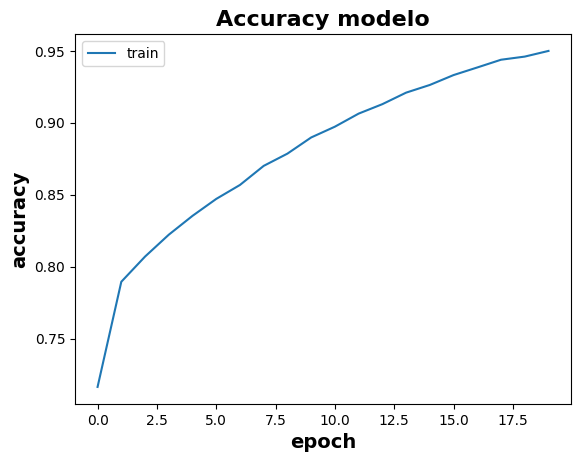

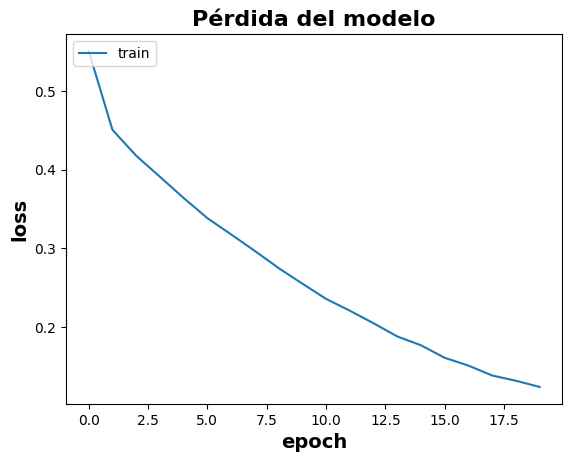

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy modelo', fontsize=16, fontweight="bold")
plt.ylabel('accuracy', fontsize=14, fontweight="bold")
plt.xlabel('epoch', fontsize=14, fontweight="bold")
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Pérdida del modelo', fontsize=16, fontweight="bold")
plt.ylabel('loss', fontsize=14, fontweight="bold")
plt.xlabel('epoch', fontsize=14, fontweight="bold")
plt.legend(['train'], loc='upper left')
plt.show()

# Cálculo de la Precisión (Accuracy)

In [ ]:
score, acc = modelo.evaluate(X_test, y_test, verbose=2, batch_size=64)
print("Score: %.2f" % (score))
print("Accuracy: %.2f" % (acc))

258/258 - 12s - 45ms/step - accuracy: 0.7392 - loss: 1.1299
Score: 1.13
Accuracy: 0.74


# Realiza Análisis de Sentimientos

Ahora es el momento de predecir el sentimiento (positividad/negatividad) de una oración dada por el usuario.

In [ ]:
twt = ['I do not recommend this product']

Luego, se tokeniza

In [ ]:
twt = tokenizer.texts_to_sequences(twt)

Luego, se rellena

In [ ]:
twt = tf.keras.preprocessing.sequence.pad_sequences(twt, maxlen=X.shape[1], dtype='int32', value=0)

Predice el sentimiento pasando la oración al modelo construido.

In [ ]:
sentiment = modelo.predict(twt, batch_size=1)[0]
print(sentiment)

if(np.argmax(sentiment) == 0):
    print(y_arr[0])
elif (np.argmax(sentiment) == 1):
    print(y_arr[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
[0.75905746 0.24094255]
Negative


#Desafío

Prueba con " I do recommend this product "....cuál es el resultado?....haz otras pruebas...